In [1]:
import findspark
findspark.init()

In [2]:
from pyspark import SparkContext, SparkConf
conf = SparkConf().setMaster('local[*]').setAppName('DataSkew')
sc = SparkContext(conf = conf)
sc.setLogLevel('ERROR')
sc

23/06/30 17:51:19 WARN Utils: Your hostname, OMEN resolves to a loopback address: 127.0.1.1; using 172.19.181.52 instead (on interface eth0)
23/06/30 17:51:19 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/06/30 17:51:20 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


<SparkContext master=local[*] appName=DataSkew>

In [3]:
def each_partition_size(rdd):
    def part_func(partition):
        _count = 0
        for i in partition:
            _count += 1
        yield  _count
    return [{'partition': idx, 'count': count} for idx, count in enumerate(rdd.mapPartitions(part_func).collect())]

In [4]:
def each_grouped_partition_size(rdd):
    def part_func(partition):
        _count = 0
        for i in partition:
            for j in i[1]:
                _count += 1
        yield  _count
    return [{'partition': idx, 'count': count} for idx, count in enumerate(rdd.mapPartitions(part_func).collect())]

In [5]:
data_sample = [(1,4),(2,2),(2,1),(3,5),(2,5),(2,10),(2,7),(3,4),(2,1),(2,4),(4,4)]
rdd_sample = sc.parallelize(data_sample, 3)

rdd_sample.glom().collect()

[[(1, 4), (2, 2), (2, 1)],
 [(3, 5), (2, 5), (2, 10)],
 [(2, 7), (3, 4), (2, 1), (2, 4), (4, 4)]]

In [6]:
each_partition_size(rdd_sample)

[{'partition': 0, 'count': 3},
 {'partition': 1, 'count': 3},
 {'partition': 2, 'count': 5}]

In [7]:
rdd_sample_grouped = rdd_sample.groupByKey()

for key, collection in rdd_sample_grouped.collect():
    print(key, [value for value in collection])

3 [5, 4]
1 [4]
4 [4]
2 [2, 1, 5, 10, 7, 1, 4]


In [8]:
each_grouped_partition_size(rdd_sample_grouped)

[{'partition': 0, 'count': 2},
 {'partition': 1, 'count': 2},
 {'partition': 2, 'count': 7}]

In [9]:
print(rdd_sample.getNumPartitions())
print(rdd_sample_grouped.getNumPartitions())

3
3


In [10]:
rdd_sample_grouped.glom().collect()

[[(3, <pyspark.resultiterable.ResultIterable at 0x7f59a80ed0c0>)],
 [(1, <pyspark.resultiterable.ResultIterable at 0x7f59a80ef910>),
  (4, <pyspark.resultiterable.ResultIterable at 0x7f59a80ef280>)],
 [(2, <pyspark.resultiterable.ResultIterable at 0x7f59a80effd0>)]]

In [49]:
import numpy as np
import random

keys_tuple = ('a',10),('b',6000000),('c',800),('d',10000)
keys = []
values = []
for key, count in keys_tuple:
    keys.extend([key]*count)
    values.extend(list(np.random.randint(low=1, high=100, size = count)))
random.shuffle(keys)
pair_skew = list(zip(keys, values))

In [50]:
len(pair_skew)

6010810

In [51]:
rdd = sc.parallelize(pair_skew, 4)

In [30]:
from time import time
def get_time(func):
    def wrapper_func(*args, **kwargs):
        t1 = time()
        func(*args, **kwargs)
        t2 = time()
        print('Took:', round(t2-t1, 4) ,'seconds')
    return wrapper_func

In [15]:
grouped_rdd = rdd.groupByKey().cache()

In [16]:
@get_time
def get_count(rdd):
    return rdd.count()


In [17]:
get_count(grouped_rdd.map(lambda pair: (pair[0], [(i+10) for i in pair[1]])))

Took: 79.5759 seconds


#### Group By Key
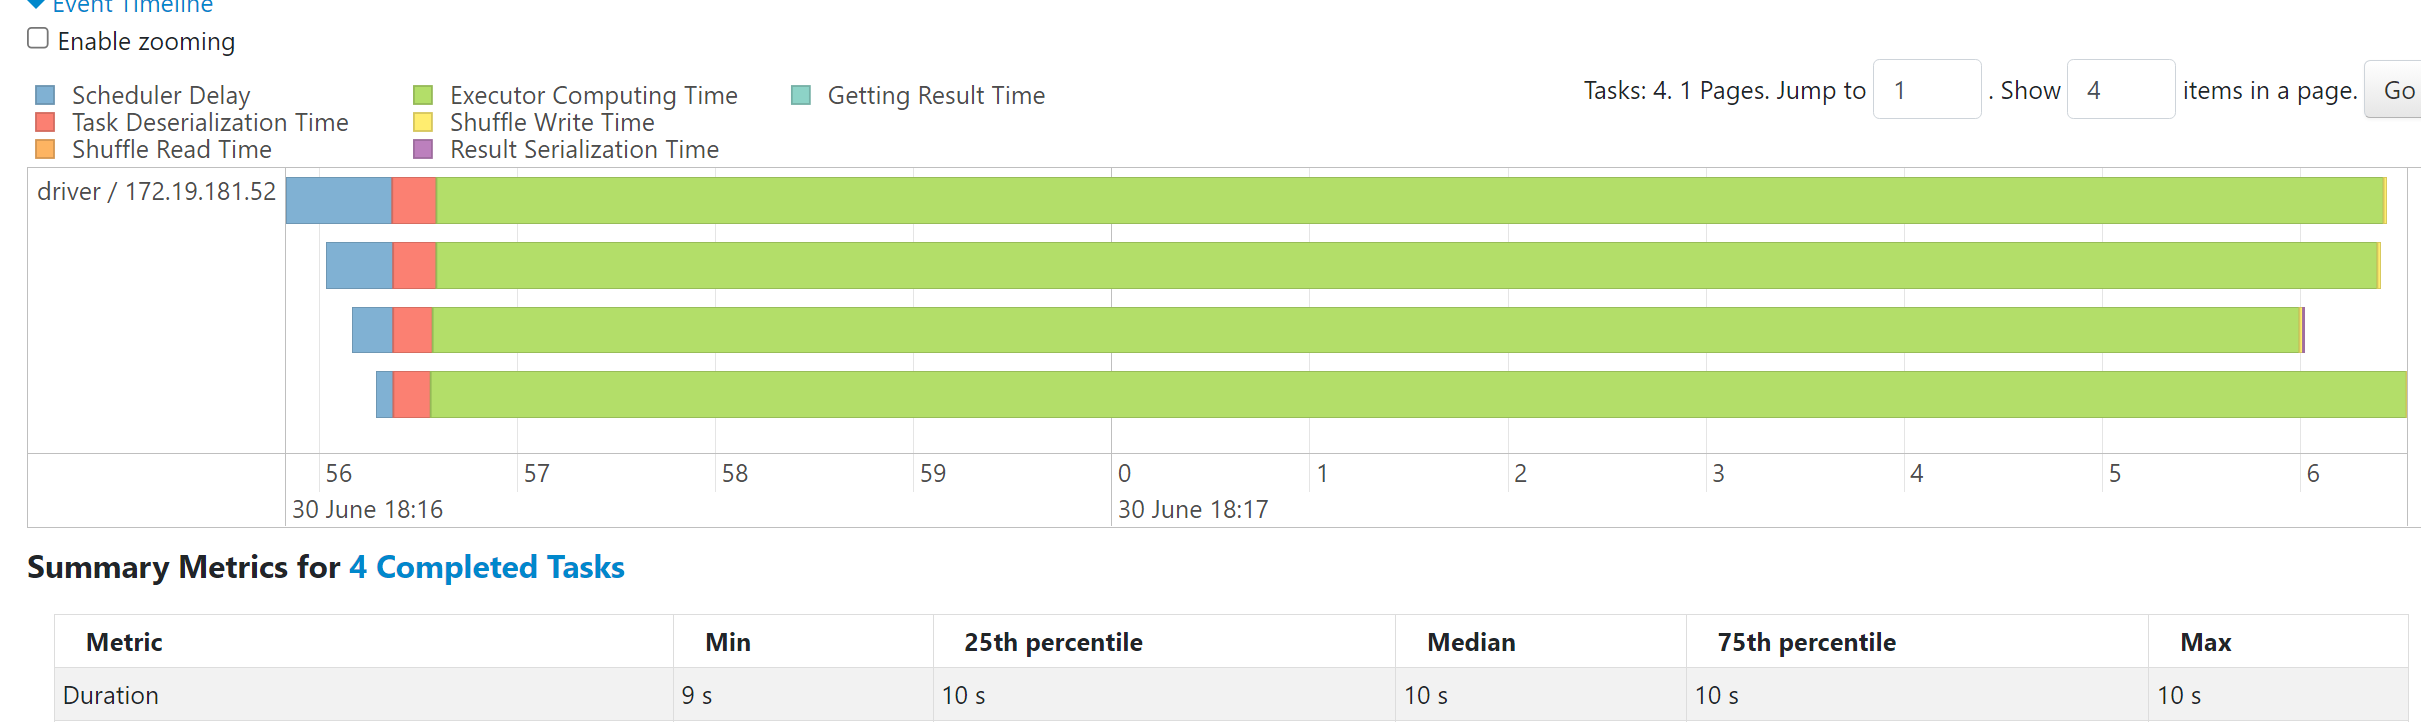

#### Count After Group By Key
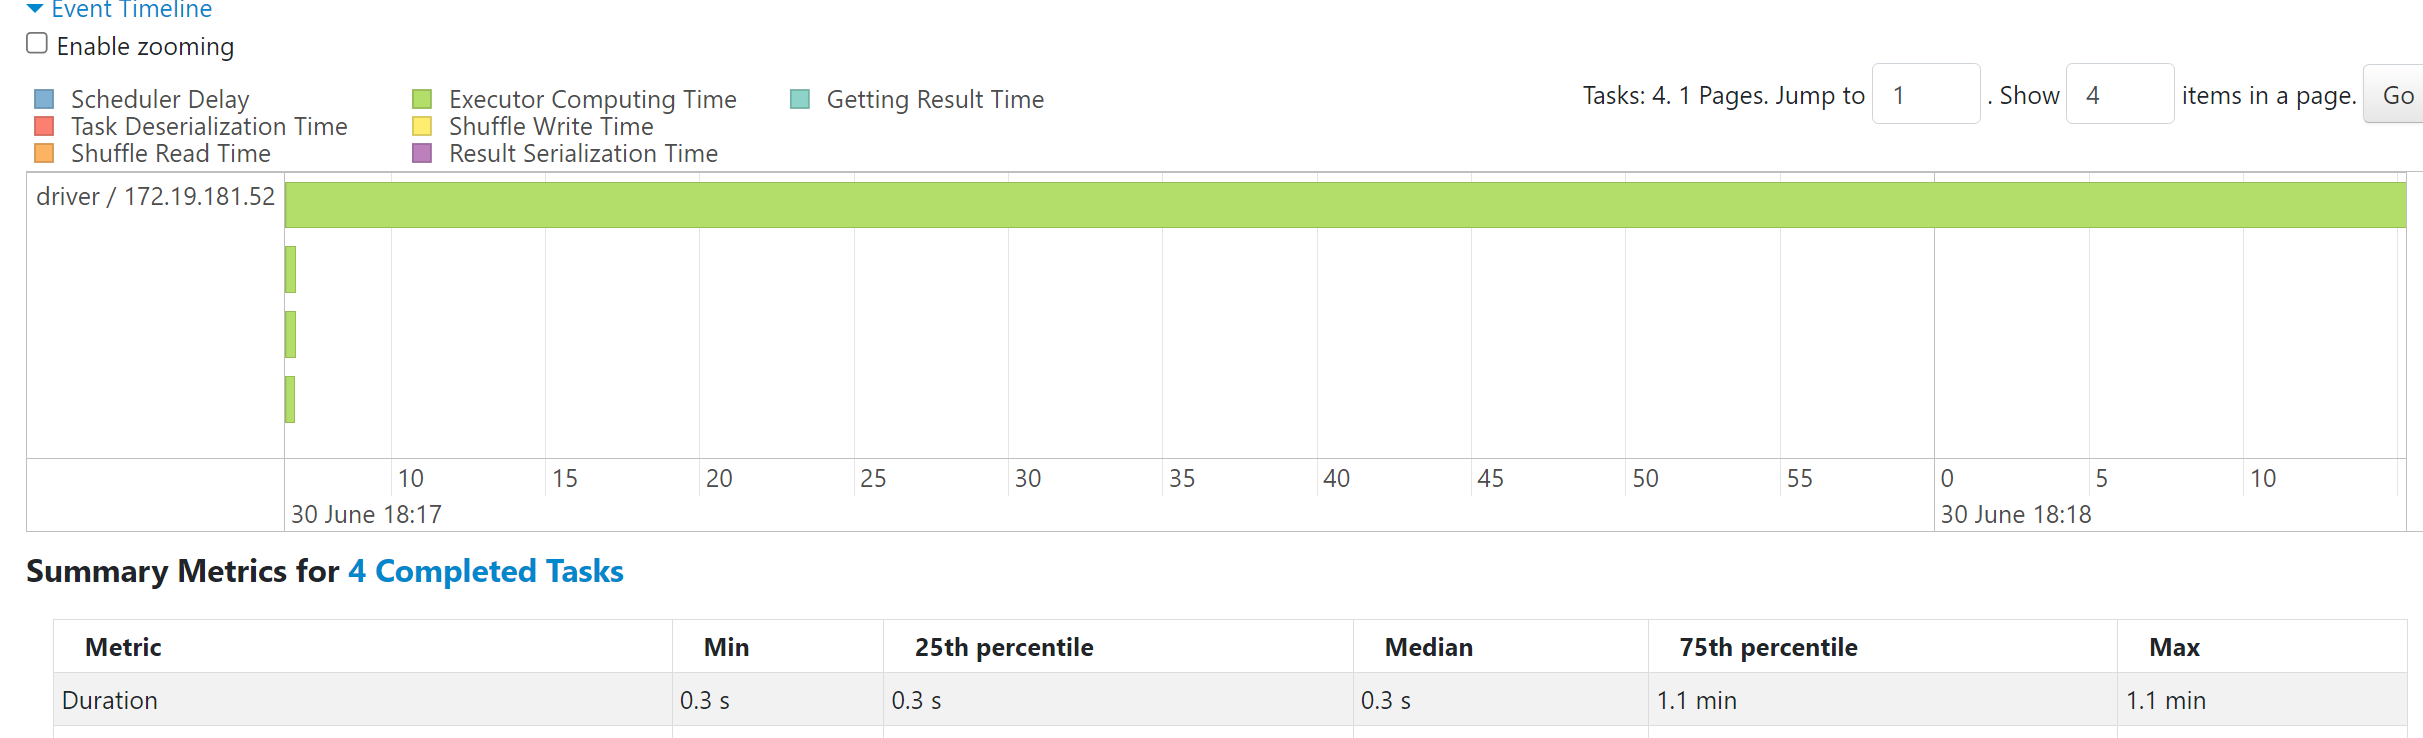

In [19]:
print(rdd.getNumPartitions())
print(each_partition_size(rdd))

4


[{'partition': 0, 'count': 1502208}, {'partition': 1, 'count': 1503232}, {'partition': 2, 'count': 1502208}, {'partition': 3, 'count': 1503162}]


In [20]:
print(grouped_rdd.getNumPartitions())

4


In [21]:
each_grouped_partition_size(grouped_rdd)

[{'partition': 0, 'count': 6000800},
 {'partition': 1, 'count': 10},
 {'partition': 2, 'count': 10000},
 {'partition': 3, 'count': 0}]

## Mitigate data skewness: SALTING

In [22]:
def salting(val):
    tmp = val + '_' + str(random.randint(0,5))
    return tmp

#### Data Skew in Grouping

In [23]:
rdd_salting = rdd.map(lambda x: (salting(x[0]), x[1]))
grouped_rdd_salted = rdd_salting.groupByKey().cache()

In [24]:
get_count(grouped_rdd_salted.map(lambda pair: (pair[0], [(i+10) for i in pair[1]])))

Took: 26.6954 seconds


#### Group By Count after Salting:
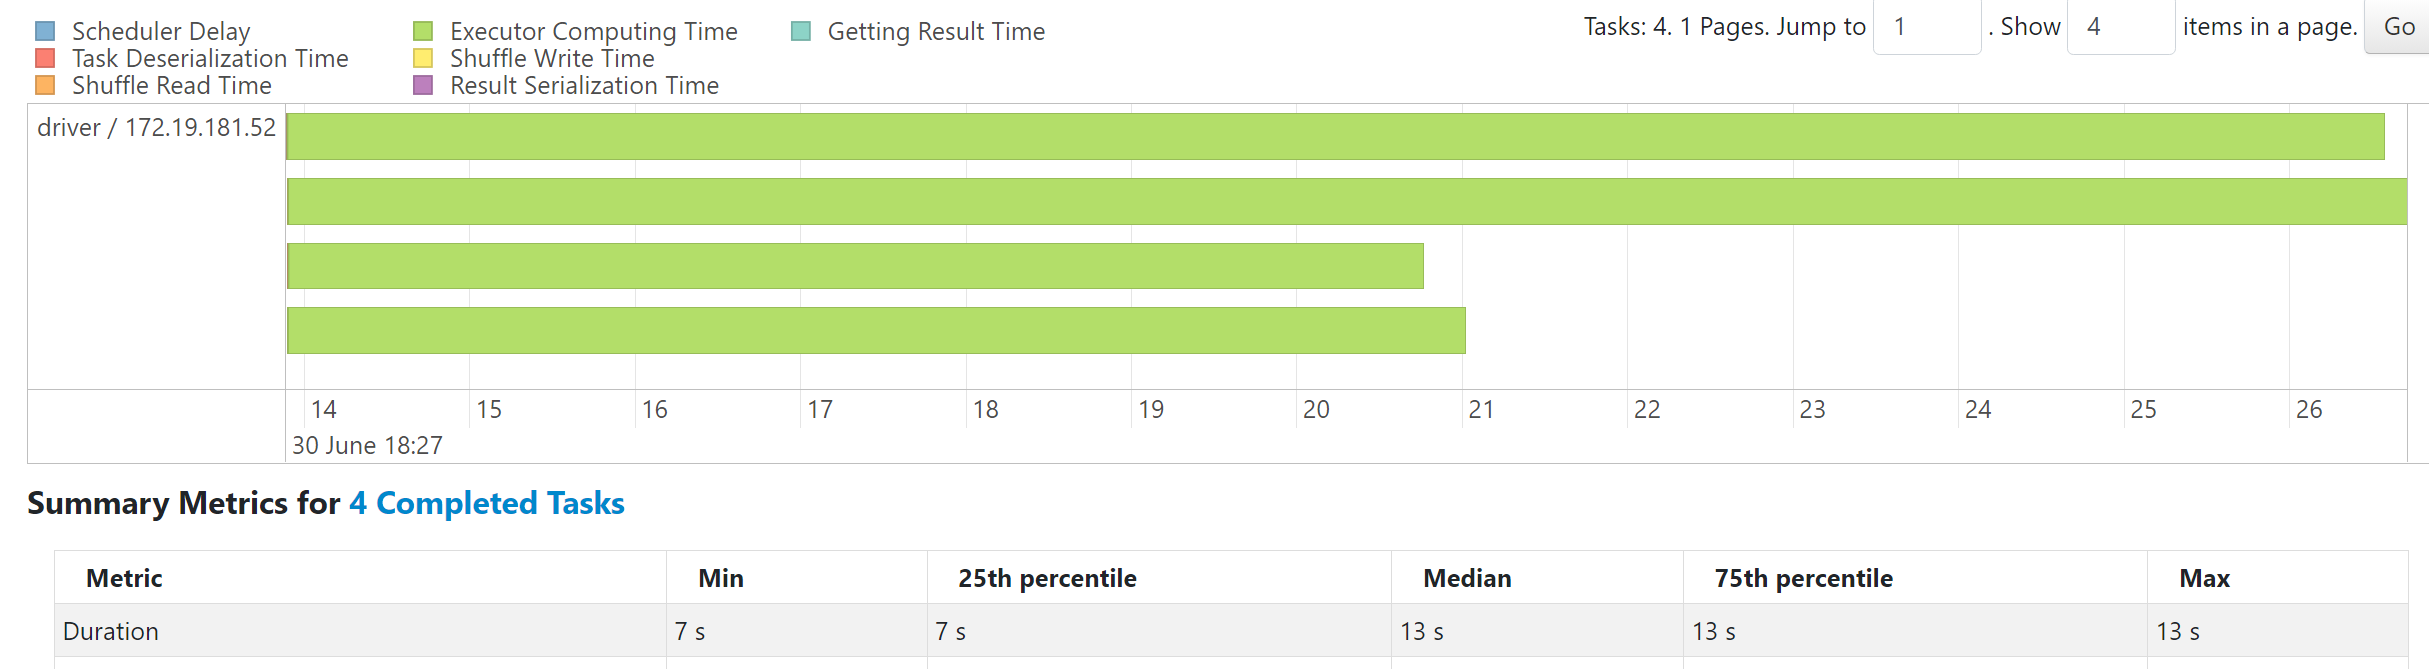

#### Time of the job reduced from 1.3 min to 27 sec

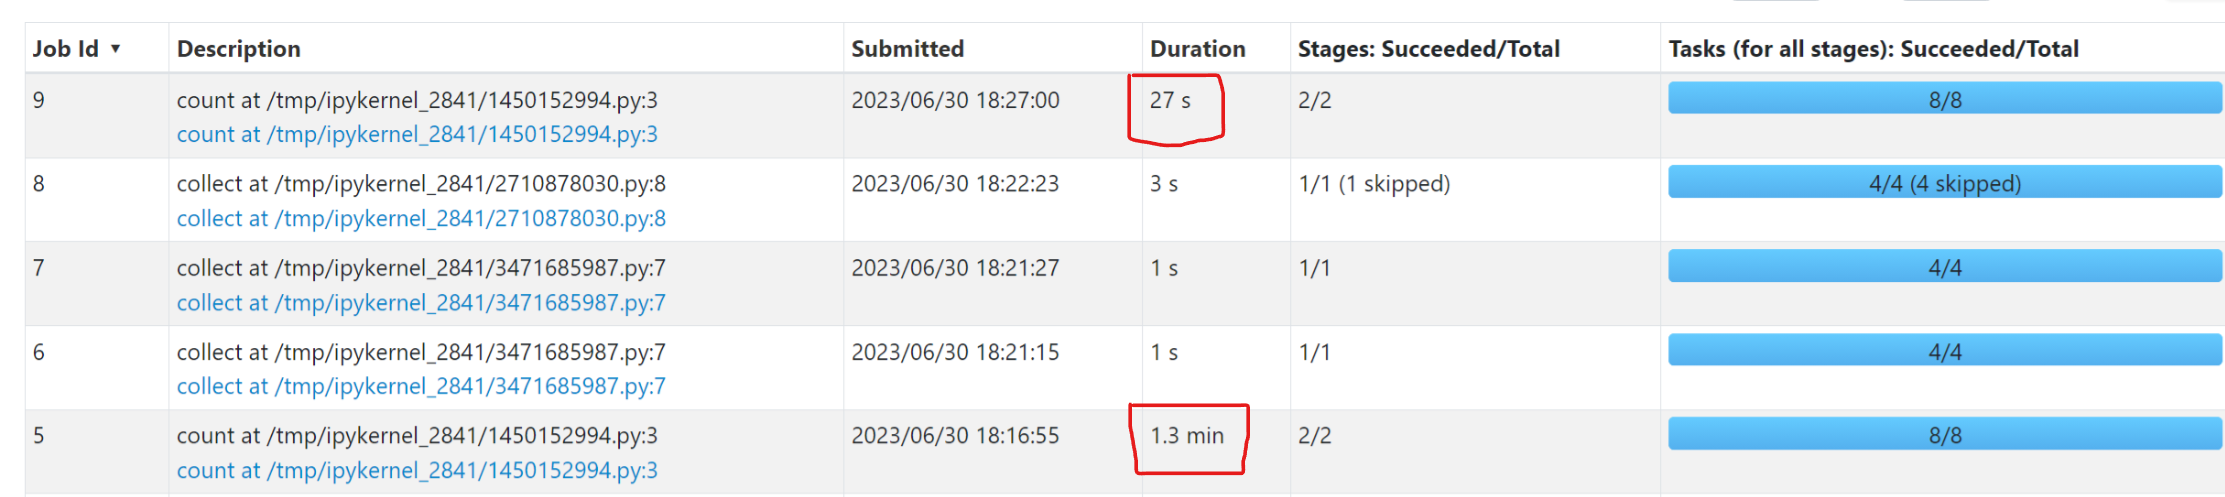

In [25]:
each_grouped_partition_size(grouped_rdd_salted)

[{'partition': 0, 'count': 2000068},
 {'partition': 1, 'count': 1002340},
 {'partition': 2, 'count': 1004304},
 {'partition': 3, 'count': 2004098}]

#### Data Skew in sort

In [32]:
rdd_sort = rdd.sortByKey(ascending=False, numPartitions=4)
get_count(rdd_sort)

Took: 37.8548 seconds


In [31]:
rdd_sort.count()

6010810

In [33]:
rdd_sort_salted = rdd_salting.sortByKey(ascending=False, numPartitions=4)
get_count(rdd_sort_salted)

Took: 17.4312 seconds


In [34]:
rdd_sort_salted.count()

6010810

In [35]:
each_partition_size(rdd_sort)

[{'partition': 0, 'count': 10800},
 {'partition': 1, 'count': 0},
 {'partition': 2, 'count': 0},
 {'partition': 3, 'count': 6000010}]

In [36]:
each_partition_size(rdd_sort_salted)

[{'partition': 0, 'count': 1012238},
 {'partition': 1, 'count': 2000411},
 {'partition': 2, 'count': 998963},
 {'partition': 3, 'count': 1999198}]

#### In the salted rdd, the records are uniformly distributed

#### salted rdd sort and count
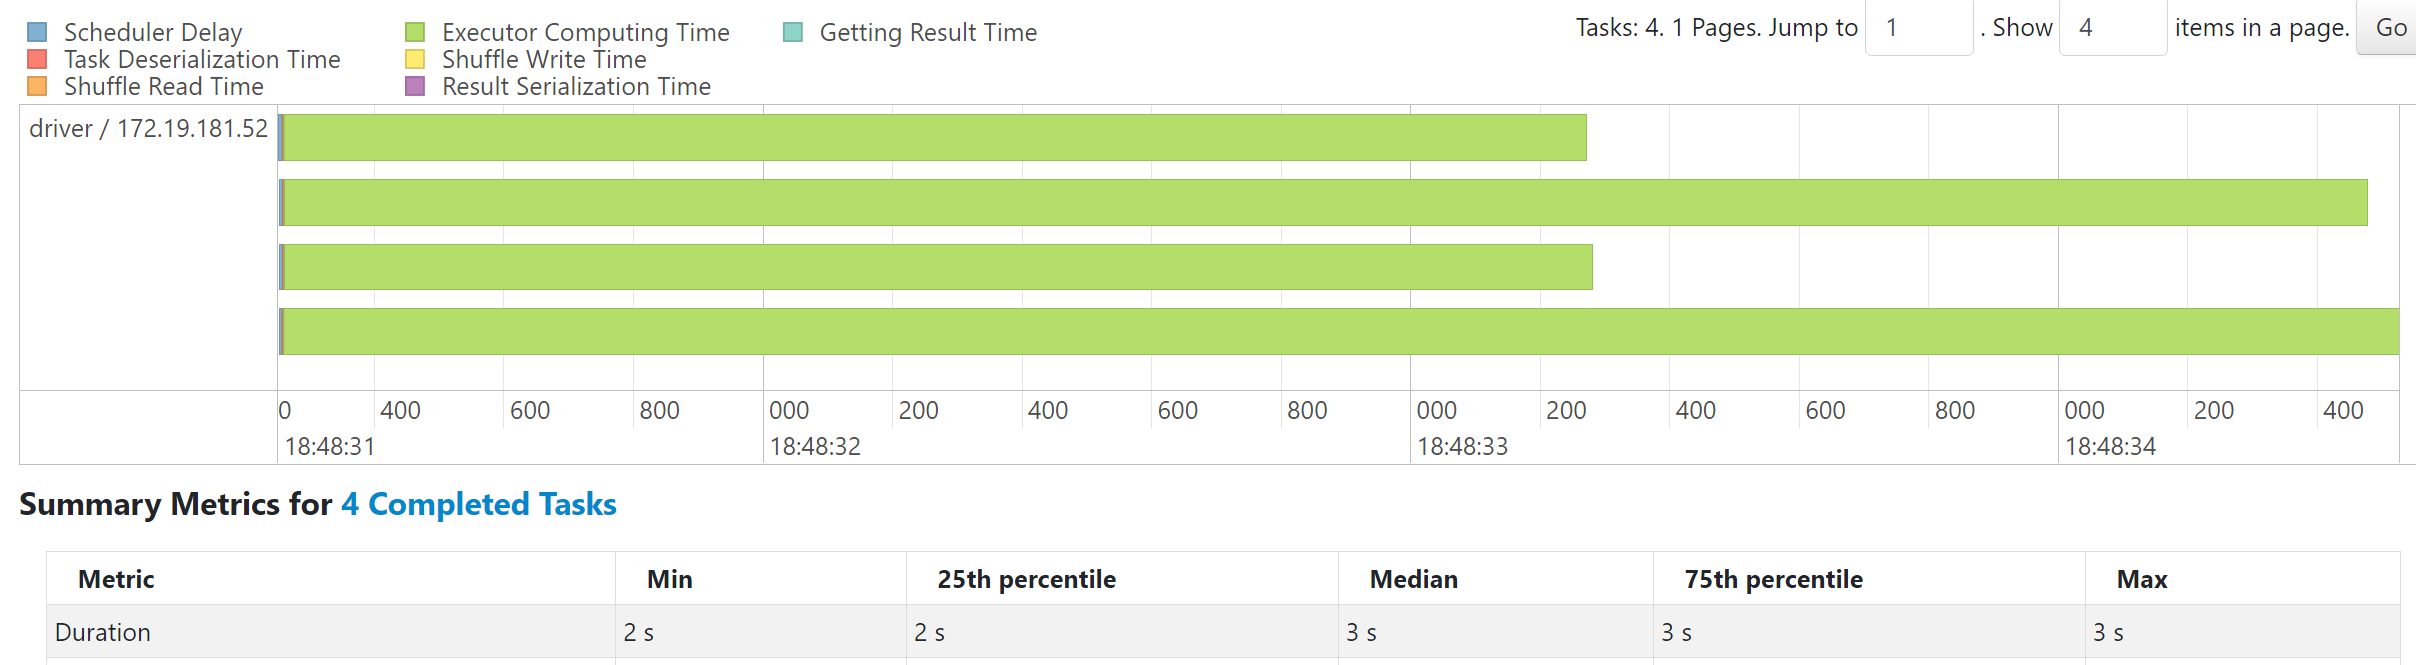

#### original rdd sort and count
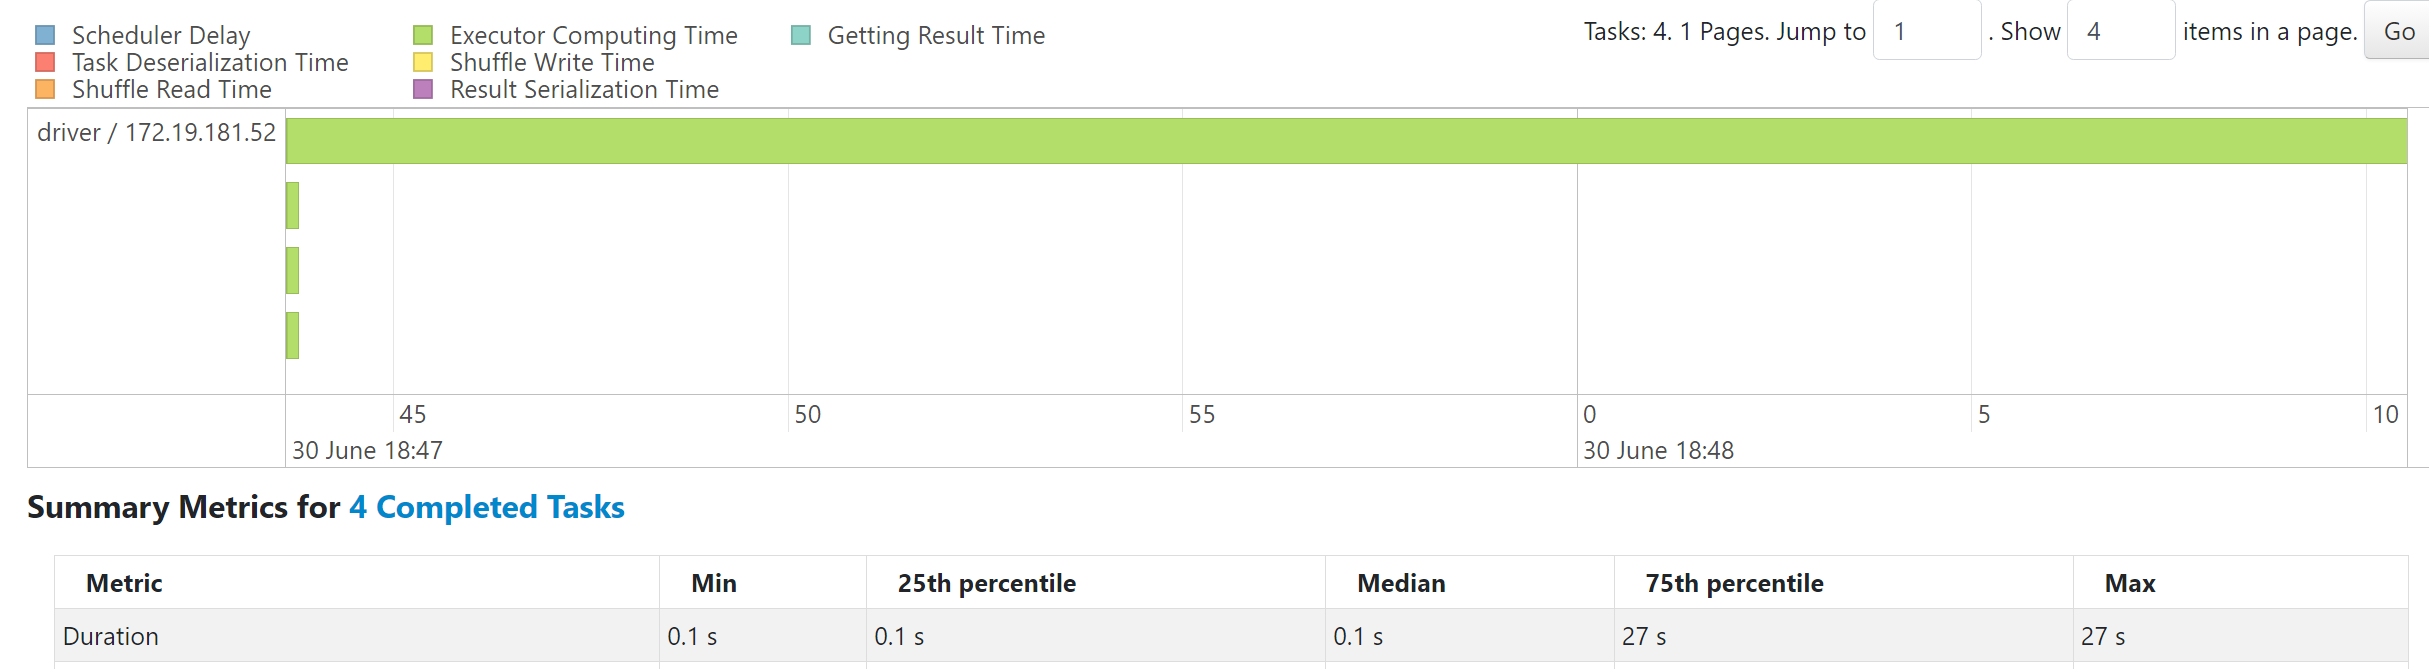

#### Data Skew in Join

In [38]:
small_rdd1 = sc.parallelize([(2,3),(1,3),(1,4),(3,1),(5,1)], 3)
small_rdd2 = sc.parallelize([(4,3),(0,1),(1,2),(2,1)], 2)
print(small_rdd1.glom().collect())
print(small_rdd2.glom().collect())

[[(2, 3)], [(1, 3), (1, 4)], [(3, 1), (5, 1)]]
[[(4, 3), (0, 1)], [(1, 2), (2, 1)]]


In [39]:
each_partition_size(small_rdd1)

[{'partition': 0, 'count': 1},
 {'partition': 1, 'count': 2},
 {'partition': 2, 'count': 2}]

In [40]:
each_partition_size(small_rdd2)

[{'partition': 0, 'count': 2}, {'partition': 1, 'count': 2}]

In [41]:
join_rdd = small_rdd1.join(small_rdd2)
join_rdd.collect()

[(1, (3, 2)), (1, (4, 2)), (2, (3, 1))]

In [42]:
join_rdd.glom().collect()

[[], [(1, (3, 2)), (1, (4, 2))], [(2, (3, 1))], [], []]

In [44]:
each_partition_size(join_rdd)

[{'partition': 0, 'count': 0},
 {'partition': 1, 'count': 2},
 {'partition': 2, 'count': 1},
 {'partition': 3, 'count': 0},
 {'partition': 4, 'count': 0}]

In [47]:
# import numpy as np
# import random
keys_tuple = ('a',5),('b',60),('c',100)
keys = []
values = []
for key, count in keys_tuple:
    keys.extend([key]*count)
    values.extend(list(np.random.randint(low=1, high=100, size = count)))
random.shuffle(keys)

pair_data = list(zip(keys, values))

In [52]:
small_rdd = sc.parallelize(pair_data, 2)

#### Join without Salting

In [53]:
rdd_join = rdd.join(small_rdd)

In [54]:
rdd_join.map(lambda x: x[1][0] + x[1][1]).reduce(lambda x,y: x+y)

35289454765

In [55]:
@get_time
def red(rdd_join):
    rdd_join.map(lambda x: x[1][0] + x[1][1]).reduce(lambda x,y: x+y)
red(rdd_join)

Took: 251.4677 seconds


In [56]:
rdd_new = rdd.map(lambda x: ((x[0], random.randint(0, 10)), x[1]) ).cache()

In [57]:
cartesian_rdd = sc.parallelize(range(11))

In [61]:
small_rdd.cartesian(cartesian_rdd).take(5)

[(('c', 89), 0),
 (('b', 93), 0),
 (('b', 28), 0),
 (('b', 19), 0),
 (('c', 11), 0)]

In [74]:
small_rdd_new = small_rdd.cartesian(cartesian_rdd).map(lambda x: ((x[0][0], x[1]), x[0][1])).coalesce(4).cache()

In [75]:
rdd_join_salting = rdd_new.join(small_rdd_new)

In [76]:
red(rdd_join_salting)

Took: 60.719 seconds


In [65]:
rdd_join_salting.map(lambda x: x[1][0] + x[1][1]).reduce(lambda x,y: x+y)

35289454765

## 251 to 60 seconds with the same answer

#### With small range of randomness
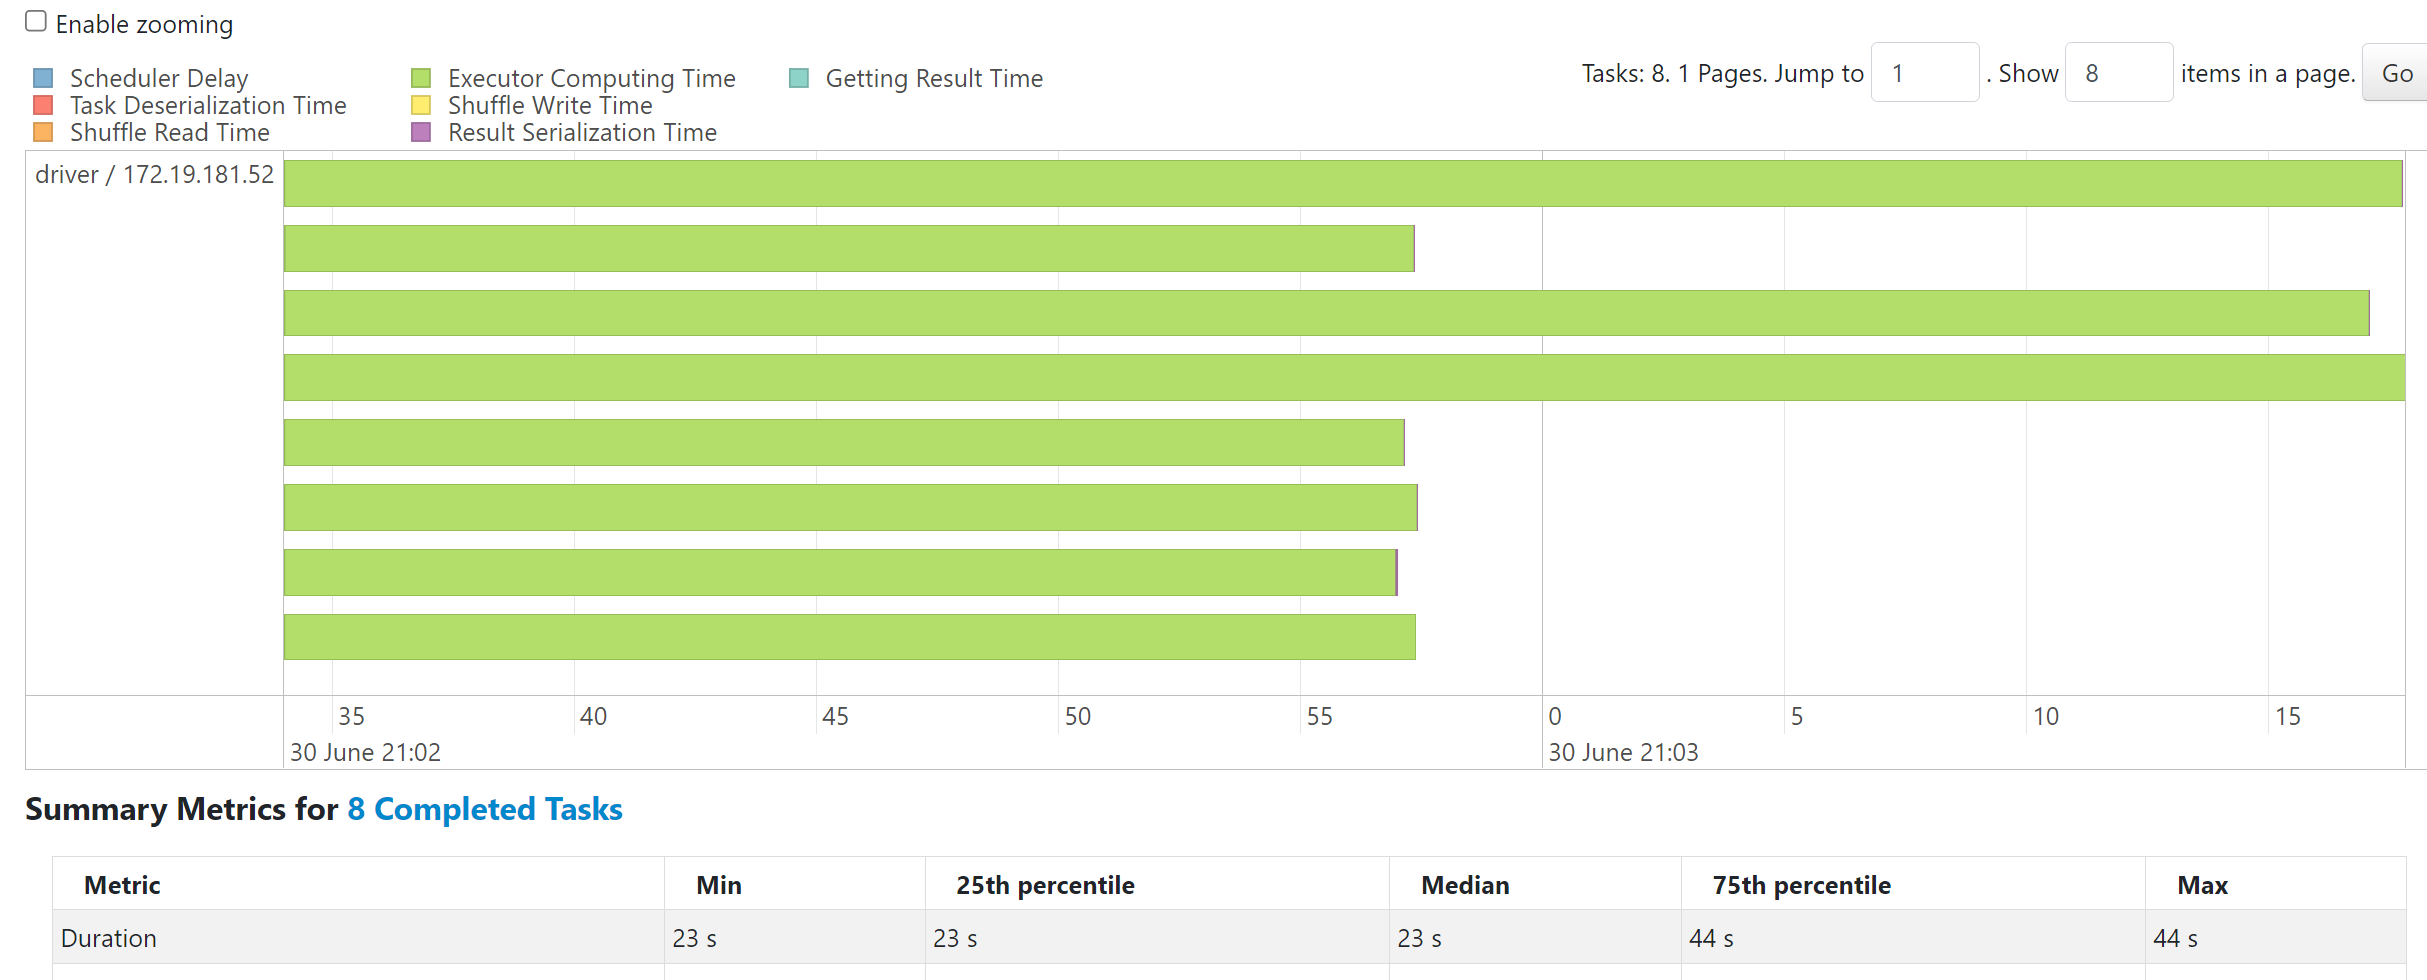

#### (key, value) -> ((key, randomInt), value) for large dataset
#### (key, value) -> ((key,value), cartesian) -> ((key, cartesian), value) for small dataset

> **Note:** range of randomInt equals to the range of cartesian

#### Let's try by increasing the range of random values

In [67]:
rdd_new_1 = rdd.map(lambda x: ((x[0], random.randint(0, 100)), x[1]))
small_rdd_new_1 = small_rdd.cartesian(sc.parallelize(range(101))).map(lambda x: ((x[0][0], x[1]), x[0][1]))

In [68]:
each_partition_size(rdd_new_1)

[{'partition': 0, 'count': 1502208},
 {'partition': 1, 'count': 1503232},
 {'partition': 2, 'count': 1502208},
 {'partition': 3, 'count': 1503162}]

In [69]:
each_partition_size(small_rdd_new_1)

[{'partition': 0, 'count': 492},
 {'partition': 1, 'count': 492},
 {'partition': 2, 'count': 492},
 {'partition': 3, 'count': 574},
 {'partition': 4, 'count': 492},
 {'partition': 5, 'count': 492},
 {'partition': 6, 'count': 574},
 {'partition': 7, 'count': 492},
 {'partition': 8, 'count': 492},
 {'partition': 9, 'count': 574},
 {'partition': 10, 'count': 492},
 {'partition': 11, 'count': 492},
 {'partition': 12, 'count': 574},
 {'partition': 13, 'count': 492},
 {'partition': 14, 'count': 492},
 {'partition': 15, 'count': 574},
 {'partition': 16, 'count': 498},
 {'partition': 17, 'count': 498},
 {'partition': 18, 'count': 498},
 {'partition': 19, 'count': 581},
 {'partition': 20, 'count': 498},
 {'partition': 21, 'count': 498},
 {'partition': 22, 'count': 581},
 {'partition': 23, 'count': 498},
 {'partition': 24, 'count': 498},
 {'partition': 25, 'count': 581},
 {'partition': 26, 'count': 498},
 {'partition': 27, 'count': 498},
 {'partition': 28, 'count': 581},
 {'partition': 29, 'coun

In [71]:
small_rdd_new_1 = small_rdd_new_1.coalesce(4)

In [72]:
each_partition_size(small_rdd_new_1)

[{'partition': 0, 'count': 4100},
 {'partition': 1, 'count': 4182},
 {'partition': 2, 'count': 4150},
 {'partition': 3, 'count': 4233}]

In [73]:
red(rdd_new_1.join(small_rdd_new_1))

Took: 52.2398 seconds


#### With large range of randomness
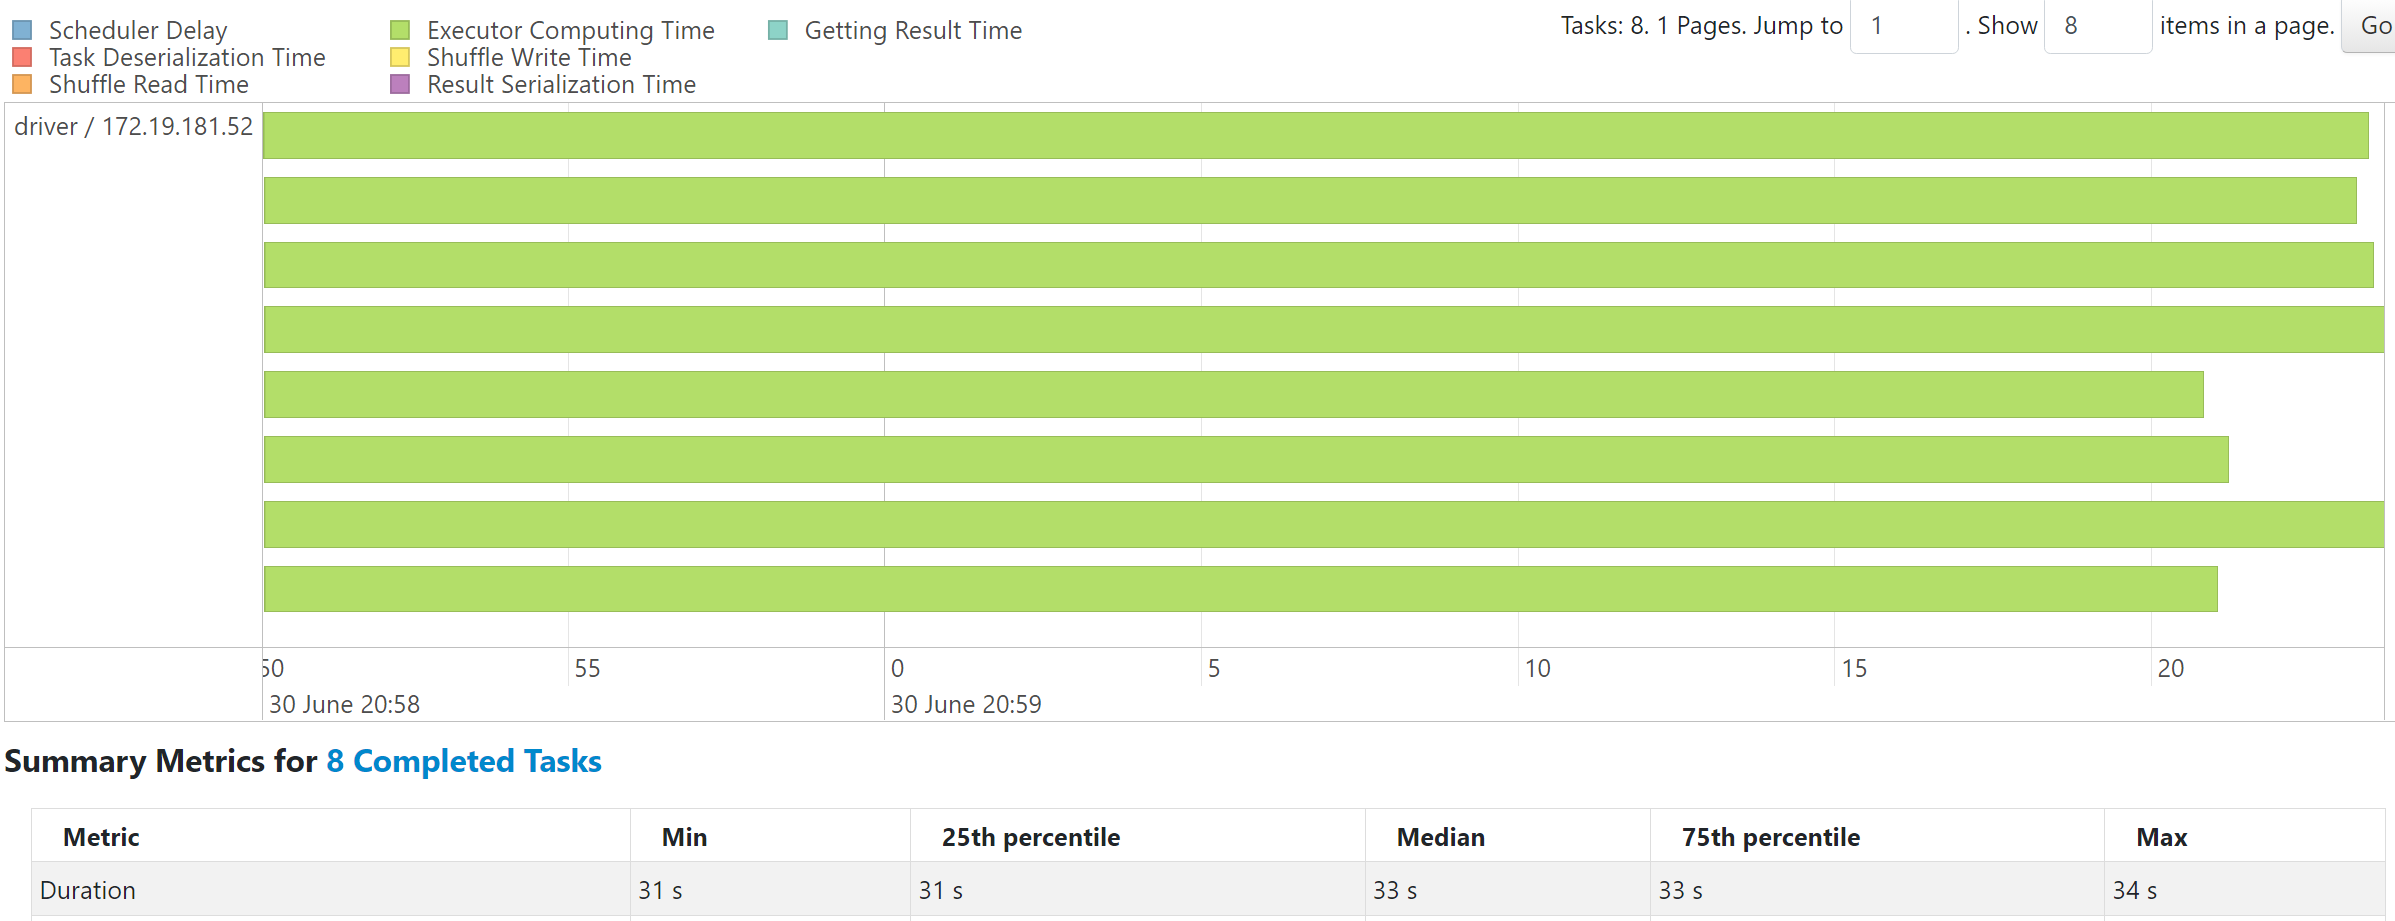

In [77]:
rdd_new_1.join(small_rdd_new_1).map(lambda x: x[1][0] + x[1][1]).reduce(lambda x,y: x+y)

35289454765